In [29]:
import sympy

# System is a vector of differential equations

system = [
    "f'=w",
    "g'=-p*q*v",
    "w'=-w+u+v",
    "u'=-u+r*v",
    "v'=-v",
    "r'=-r**2",
    "p'=p*v",
    "q'=v-q"
]

# Init is a vector representing the system's initial condition

init = [0, 0, 0, 0, 0, 1, 1, 1]

In [30]:
# Utilities for handling the initial conditions

def split_eq(equation: str) -> list[str]:
    return equation.split("=")


def extract_dv(eq: str) -> str:
    lhs = split_eq(equation=eq)[0]
    if len(lhs) == 1: 
        return lhs
    if lhs.endswith("_prime"):
        parts = lhs.split("_prime")
        dv = ""
        for part in parts[:-1]:
            dv += part
        return dv
    if lhs.endswith("'"):
        return lhs.split("'")[0]

def extract_ivars(eq: str):
    rhs = split_eq(equation=eq)[1]
    expr = sympy.parse_expr(rhs)
    return expr.free_symbols

def rewrite_eq_with_init(eq: str, init: float) -> str: 
    parts = split_eq(equation=eq)
    lhs = parts[0]
    rhs = parts[1]
    dv = extract_dv(eq=eq)
    replace_with = dv
    if init > 0:
        replace_with += f"+{init}"
    elif init < 0:
        replace_with += f"-{init}"
    replace_with = f"({replace_with})"
    rhs = rhs.replace(dv, replace_with)
    result = lhs + "=" + rhs
    return result 

In [31]:
# Expression parsing utilities

import sympy

def parse_rhs(expr: str):
    return sympy.parse_expr(expr)

In [68]:
%matplotlib inline

import sys
import networkx as nx
import matplotlib.pyplot as plt

from networkx import DiGraph 

class CrnEquation:
    """
    Expects a single equation and its numeric initial condition
    """
    def __init__(self, eq: str, init: float):
        self.original = eq
        if init == 0:
            self.adjusted = eq
        else:
            self.adjusted = rewrite_eq_with_init(eq=eq, init=init)
        self.dv = extract_dv(eq=eq)
        self.parts = self.adjusted.split("=")
        self.expanded = sympy.expand(self.parts[1])
        self.is_crn_computable = self.crn_computable()
        self.ivars = extract_ivars(eq=eq)

    def crn_computable(self) -> bool:
        rhs = str(self.expanded)
        rhs = sympy.parse_expr(rhs)
        pos, neg = self.split_rhs(rhs)

        # CONDITION ONE 
        # Determine whether a negative constant exists. If one does, the expression is not CRN computable
        for el in neg:
            match type(el):
                case sympy.core.numbers.Integer:
                    cast = int(el)
                    if cast < 0:
                        return False
                case sympy.core.numbers.Float:
                    cast = float(el)
                    if cast < 0:
                        return False    
                # CONDITION TWO
                # Determine whether ALL expressions with negative terms on the RHS contain the dependent variable. If not, the expression is
                # not CRN computable 
                case _:
                    expr = sympy.parse_expr(str(el))
                    if sympy.Symbol(self.dv) in expr.free_symbols:
                        continue
                    else:
                        return False
        return True 

    def split_rhs(self, rhs):
        ispos = lambda x: x.as_coeff_Mul()[0].is_positive
        pos, neg = sympy.sift(sympy.Add.make_args(rhs), ispos, binary=True)
        return pos, neg 

    def solo_term(self):
        pass

    def __str__(self):
        return f"""
            CrnEquation [ 
                original: {self.original},
                dv: {self.dv}
                ivars: {self.ivars},
                adjusted: {self.adjusted},
                expanded: {self.expanded}
                parts: {self.parts},
                crn_computable: {self.is_crn_computable}
            ]"""

    def __repr__(self):
        return str(self) 

class Crn:
    """
    Expects a vector of differential equations and an equal-sized vector of initial conditions
    """
    def __init__(self, system: list[str], init: list[float]):
        self.original_system = system
        self.system: list[CrnEquation] = []
        self.init = init
        self.rewrite_queue: list[CrnEquation] = []
        if len(self.original_system) != len(self.init):
            sys.exit(1)
        self.handle_initial_values()
        for eq in self.system:
            if not eq.is_crn_computable:
                self.rewrite_queue.append(eq)
        self.graph = self.build_graph()
        
    def build_graph(self) -> DiGraph:
        graph = DiGraph()
        for eq in self.system:
            # Apply observations here
            for ivar in eq.ivars:
                graph.add_edge(eq.dv, ivar)
        return graph

    def handle_initial_values(self): 
        for eq, init in zip(self.original_system, self.init):
            crn_equation = CrnEquation(eq=eq, init=init)
            self.system.append(crn_equation)

    def show_graph(self):
        edge_colours = ["black"]
        edges = self.graph.edges
        pos = nx.spring_layout(self.graph, k=1, iterations=20)
        nx.draw_networkx_nodes(self.graph, pos, node_size = 500)
        nx.draw_networkx_labels(self.graph, pos)
        nx.draw_networkx_edges(self.graph, pos, edgelist=edges, edge_color='k', arrows=True, arrowsize=10)
        plt.show()

    def __str__(self):
        return f"""
Crn [
    system: {self.system}
    rewrite_queue: {self.rewrite_queue},
]
"""

In [69]:
crn = Crn(system=system, init=init)
print(crn)


Crn [
    system: [
            CrnEquation [ 
                original: f'=w,
                dv: f
                ivars: {w},
                adjusted: f'=w,
                expanded: w
                parts: ["f'", 'w'],
                crn_computable: True
            ], 
            CrnEquation [ 
                original: g'=-p*q*v,
                dv: g
                ivars: {p, q, v},
                adjusted: g'=-p*q*v,
                expanded: -p*q*v
                parts: ["g'", '-p*q*v'],
                crn_computable: False
            ], 
            CrnEquation [ 
                original: w'=-w+u+v,
                dv: w
                ivars: {u, w, v},
                adjusted: w'=-w+u+v,
                expanded: u + v - w
                parts: ["w'", '-w+u+v'],
                crn_computable: True
            ], 
            CrnEquation [ 
                original: u'=-u+r*v,
                dv: u
                ivars: {r, u, v},
                adjusted: u'=

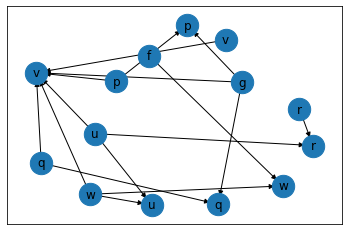

In [70]:
crn.show_graph()